# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import data processing libraries
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder,JamesSteinEncoder

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree



# import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn_evaluation import plot
import graphviz

import warnings
warnings.filterwarnings('ignore')

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

We  collected  data  from  a  Portuguese  bank  that  used  its 
own  contact-center  to  do  directed  marketing  campaigns. 
The telephone, with a human agent as the interlocutor, was 
the dominant marketing channel, although sometimes with 
an  auxiliary  use  of  the  Internet  online  banking  channel 
(e.g.  by  showing  information  to  specific  targeted  client). 
Furthermore, each campaign was managed in an integrated fashion and the results for all channels were outputted 
together.

The dataset collected is related to 17 campaigns that 
occurred between May 2008 and November 2010, 
corresponding  to  a  total  of  79354  contacts.  During  these 
phone campaigns, an attractive long-term deposit 
application, with good interest rates, was offered. For each 
contact,  a  large  number  of  attributes  was  stored  (e.g.  see 
Table  2)  and  if  there  was  a  success  (the  target  variable). 
For the whole database considered, there were 6499 
successes (8% success rate). 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# find out the null values
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# find out the na values
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

This dataset doesnt have any  null and na values.

In [8]:
# lets check for duplicates
print('Duplicated Row: ',bank_df.duplicated().sum())

Duplicated Row:  12


#### Understanding all dataset

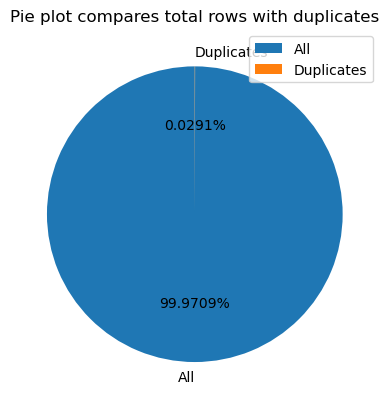

In [9]:
#lets plot the duplicates
labels = ['All', 'Duplicates']
counts = [len(bank_df),len(bank_df[bank_df.duplicated()])]
plt.pie(counts,labels=labels,autopct='%1.4f%%', startangle=90)
plt.title("Pie plot compares total rows with duplicates")
plt.legend()
plt.show()

These seems 12 rows of duplicates in the dataset, lets cleanup these since they will impact the performacne of the model.

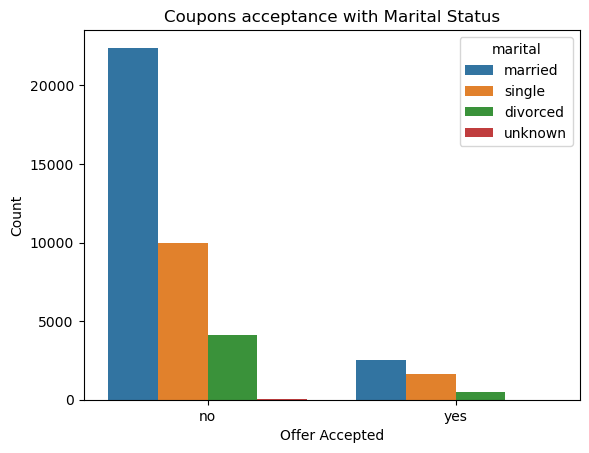

In [10]:
# Check how many people accepted the offer vs not using bar plot with respective to marital status
plt.title("Coupons acceptance with Marital Status")
sns.countplot(bank_df,x='y',hue='marital')
plt.xlabel('Offer Accepted')
plt.ylabel('Count')
plt.show()

The plot shows that lot of people didnt accepted the offers and married accepted alont than other individuals.

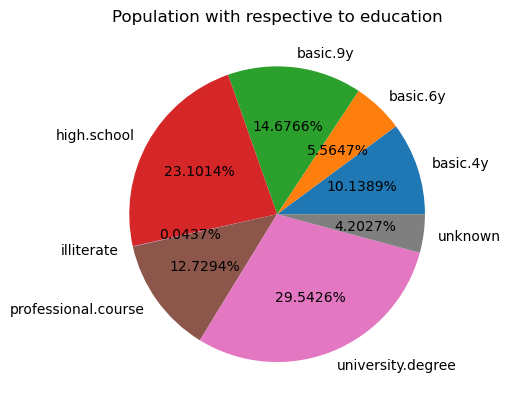

In [11]:
by_education = bank_df.groupby('education').size()
plt.title('Population with respective to education')
plt.pie(by_education,labels=by_education.index,autopct='%1.4f%%')
plt.show()

Close to 50% of the people are having university degree and high school educated and rest are others.

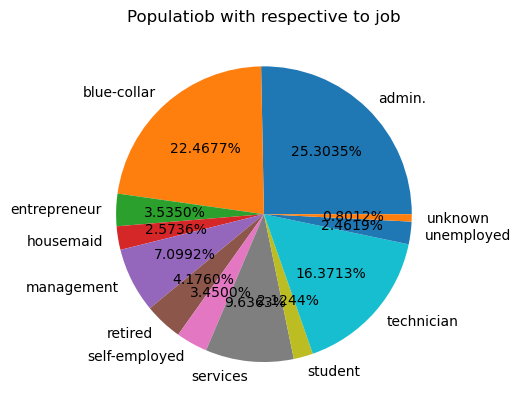

In [12]:
by_job = bank_df.groupby('job').size()
plt.title('Populatiob with respective to job')
plt.pie(by_job,labels=by_job.index,autopct='%1.4f%%')
plt.show()

In this dataset, blue-collor and admin are close to 50% of population and rest all others with various jobs.

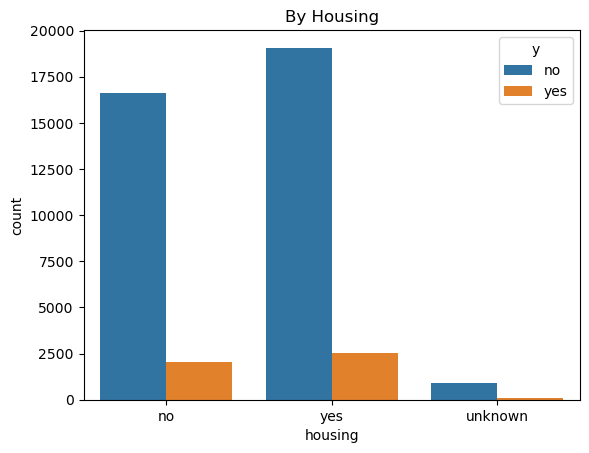

In [13]:
plt.title('By Housing')
sns.countplot(bank_df,x = 'housing', hue='y')
plt.show()

This plot shows the people with housing accepted lot of offers than others.

<Axes: xlabel='contact', ylabel='age'>

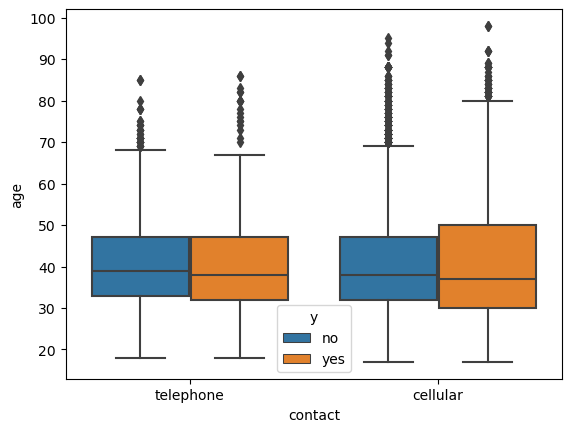

In [14]:
sns.boxplot(data=bank_df, x="contact",y="age", hue="y")

(array([36548.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4640.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

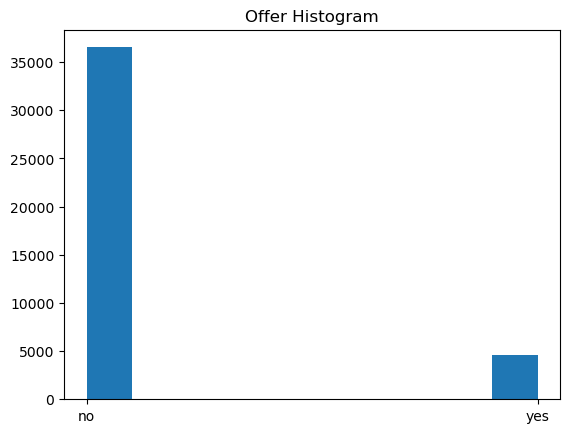

In [15]:
# histogram of offer data
plt.title('Offer Histogram')
plt.hist(bank_df['y'])

In this dataset there are more than 90% of people didnt accepted any offers so when we split the dataset into train and test sets we need to make sure it should have the similar data distribution otherwise we may see wrong predictions.

It seems the people who are contacted through celluar offered more offers than others and who are in the age of 30-50.

#### Offers Accepted Analysis
Lets understand the population who accepted offers and see how we can improve sending offers to make most out of it

In [16]:
# get the data only for offer accepted
offers_accepted = bank_df.query("y == 'yes'")
offers_accepted.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


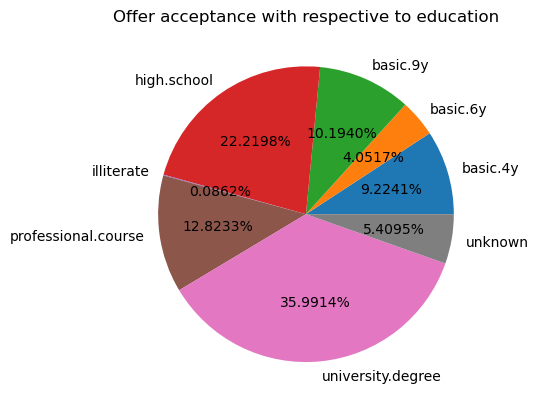

In [17]:
offers_accepted_by_education = offers_accepted.groupby('education').size()
plt.title('Offer acceptance with respective to education')
plt.pie(offers_accepted_by_education,labels=offers_accepted_by_education.index,autopct='%1.4f%%')
plt.show()

People who has university degree accepted more offers than any other people with respective to education.

<Axes: xlabel='contact', ylabel='age'>

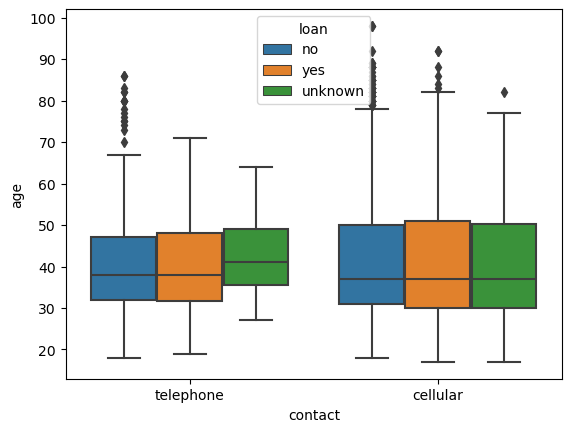

In [18]:
# box plot for with load data
sns.boxplot(data=offers_accepted, x="contact",y="age", hue="loan")

People who has loans are accepting many bank offers than other people and who are contacted through cellular phones.

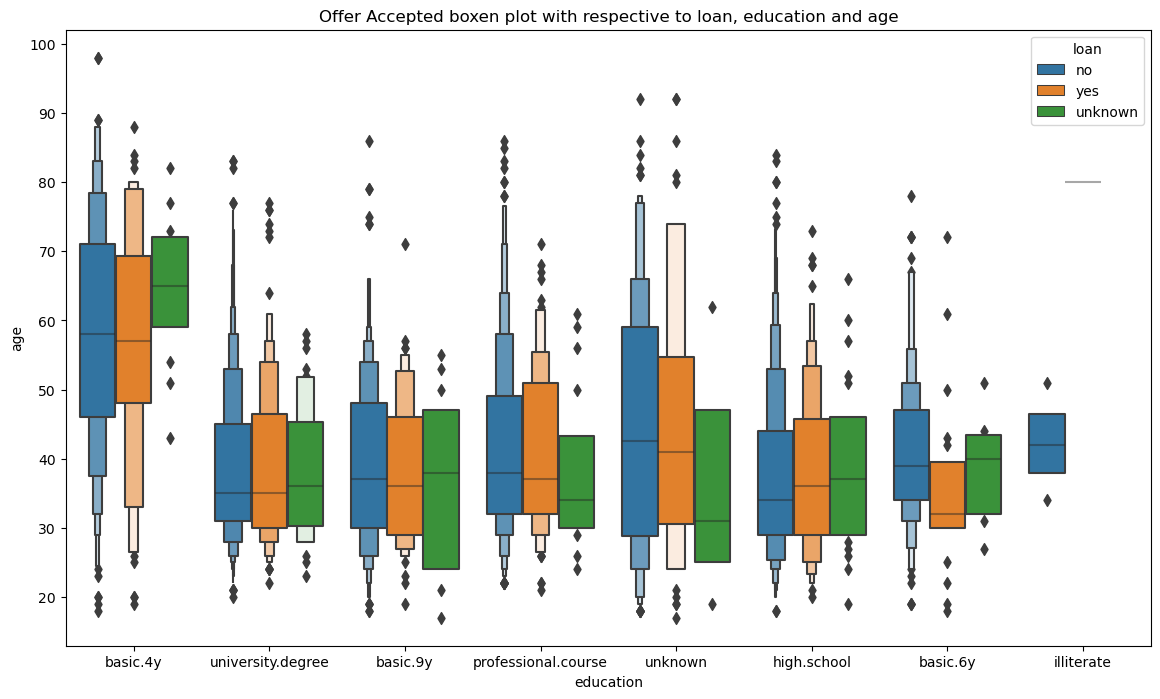

In [19]:
plt.figure(figsize=(14,8))
plt.title("Offer Accepted boxen plot with respective to loan, education and age")
sns.boxenplot(data=offers_accepted, x="education",y="age", hue="loan")
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The goal of this activity is to build a model to predict who accepts the offers and who dont. This will help the businees people to build better campaigns to improve the effectiveness of the offer campaigns.

This will help businees people to predict in advance and improve the dataset to eliminate the waste.

### Problem 5: Data Processing
Lets process the data for training the models.

#### Duplicates Cleanup

In [20]:
# lets remove the duplicate rows
bank_df_processed = bank_df.drop_duplicates()

In [21]:
#delete null and na records
bank_df_processed.dropna(inplace=True)

In [22]:
bank_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

After data processing the dataset doesnt hanve any nulls/na records.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

#### Categorical Encoding

There are quite a few categorical features, and in these *education*, *month*, *day_of_week* are ordinal categories for which probably  we need to use **OrinalEncoder** and for other we can use **LabelEncoder**

In [23]:
# create ordered categorical values for OrinalEncoding, since we wanted to retain the order of these values
month_values_order=[['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
day_of_week_values_order = [['mon','tue','wed','thu','fri','sat','sun']]
education_values_order = [['unknown','illiterate','basic.4y', 'basic.6y', 'basic.9y', 'high.school','university.degree','professional.course']]

# build column transformer for encoding ordinal features
ordinal_encoder_transformer = make_column_transformer(
    (OrdinalEncoder(categories=education_values_order), ['education']),
    (OrdinalEncoder(categories=month_values_order), ['month']),
    (OrdinalEncoder(categories=day_of_week_values_order), ['day_of_week']),
    remainder='passthrough'  # otherwise it will encode only the above 3 features and drop others
)

In [24]:
nominal_columns = ['job','marital','default','housing','loan','contact','poutcome','y']
for col in nominal_columns:
    bank_df_processed[col] = LabelEncoder().fit_transform(bank_df_processed[col])

bank_df_processed.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,basic.4y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,high.school,1,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,high.school,0,2,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,basic.6y,0,0,0,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,high.school,0,0,2,1,may,mon,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [25]:
# encode ordinal columns
ordinal_bank_df = bank_df_processed[['education','month','day_of_week']]
bank_df_processed_encoded = ordinal_encoder_transformer.fit_transform(ordinal_bank_df)
bank_df_encoded = pd.DataFrame(bank_df_processed_encoded,columns=ordinal_bank_df.columns)
bank_df_encoded.head()
bank_df_processed.drop(['education','month','day_of_week'],axis=1, inplace=True)


In [26]:
bank_df_encoded_processed = pd.concat([bank_df_processed,bank_df_encoded],axis=1)
bank_df_encoded_processed.head()

,age,job,marital,default,housing,loan,contact,duration,campaign,pdays,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education,month,day_of_week
0,56.0,3.0,1.0,0.0,0.0,0.0,1.0,261.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,2.0,4.0,0.0
1,57.0,7.0,1.0,1.0,0.0,0.0,1.0,149.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0
2,37.0,7.0,1.0,0.0,2.0,0.0,1.0,226.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0
3,40.0,0.0,1.0,0.0,0.0,0.0,1.0,151.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,3.0,4.0,0.0
4,56.0,7.0,1.0,0.0,0.0,2.0,1.0,307.0,1.0,999.0,...,1.0,1.1,93.994,-36.4,4.857,5191.0,0.0,5.0,4.0,0.0


In [27]:
bank_df_encoded_processed.dropna(inplace=True)
bank_df_encoded_processed.isnull().sum()

age               0
job               0
marital           0
default           0
housing           0
loan              0
contact           0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
education         0
month             0
day_of_week       0
dtype: int64

#### Selecting Features
Lets select columns 1-7 and do the modeling

In [28]:
# select first 7 columns
selected_df = bank_df_encoded_processed[['age',	'job',	'marital',	'default',	'housing',	'loan',	'education','y']]
selected_df.head()

,age,job,marital,default,housing,loan,education,y
0,56.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0
1,57.0,7.0,1.0,1.0,0.0,0.0,5.0,0.0
2,37.0,7.0,1.0,0.0,2.0,0.0,5.0,0.0
3,40.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
4,56.0,7.0,1.0,0.0,0.0,2.0,5.0,0.0


In [29]:
X = selected_df.drop('y',axis=1)
y = selected_df['y']

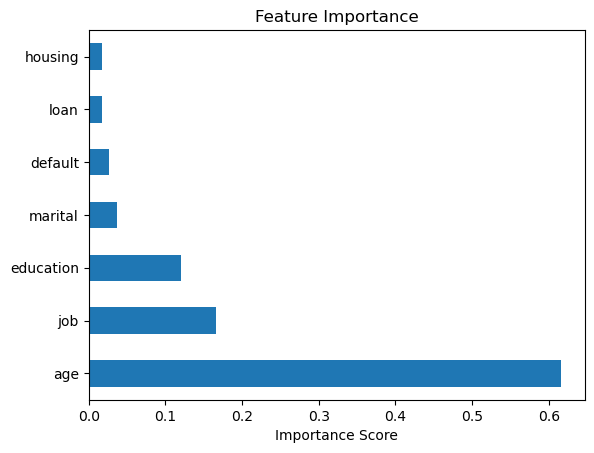

In [30]:
# find out the feature importance
model = ExtraTreesClassifier().fit(X,y)
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

The higher the score is the more importance feature it is. So the bottom features on the above plot are important features to select in model training.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [31]:
#apply standard scaler to scale the data
X = StandardScaler().fit_transform(X)

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

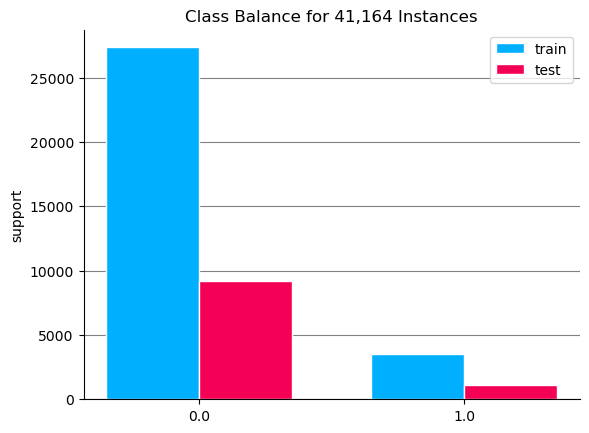

In [33]:
plot.target_analysis(y_train, y_test)
plt.show()

It shows that the data is evenly split with classes across train and test splits.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline performance for this use should at least 90% accuracy.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [34]:
# a function to fit the model, compute the model train time, train score and test score.
def train_model(model):
    m_start = time.time()
    m = model.fit(X_train,y_train)
    m_end = time.time()
    m_fit_time = m_end - m_start
    m_train_score = m.score(X_train,y_train)
    m_test_score = m.score(X_test,y_test)
    return m_train_score,m_test_score,m_fit_time

In [35]:
lgr = LogisticRegression()
lgr_train_score,lgr_test_score,lgr_fit_time=train_model(lgr)
print(lgr_train_score,lgr_test_score,lgr_fit_time)

0.8858873449292262 0.8919444174521427 0.05074501037597656


The simple Logistic Regression model's train score is 88% and test score is 89% which is performing pretty good. Lets build few more classifications models and tune hyper parameters and try to improve the model performance.

### Problem 9: Score the Model

What is the accuracy of your model?

In [36]:
#accuracy score
accuracy_score(y_test,lgr.predict(X_test))


0.8919444174521427

The accuracy score of the basis Logistic Regression is 89% which is close to our baseline expected performance.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [37]:
#KNN Model
knn = KNeighborsClassifier()
knn_train_score,knn_test_score,knn_fit_time = train_model(knn)
print(knn_train_score,knn_test_score,knn_fit_time)


0.8913937744955138 0.8839762899621028 0.03430604934692383


In [38]:
dtree = DecisionTreeClassifier()
dtree_train_score,dtree_test_score,dtree_fit_time = train_model(dtree)
print(dtree_train_score,dtree_test_score,dtree_fit_time)

0.9228128137855084 0.8621125255077252 0.07922577857971191


In [39]:
svc = SVC()
svc_train_score,svc_test_score,svc_fit_time = train_model(svc)
print(svc_train_score,svc_test_score,svc_fit_time)

0.886697113983092 0.8913613837333593 64.36599588394165


In [40]:
# build a dataframe with model performances
model_dict = {
    'model': ['LogisticRegression','KNN','DecisionTreeClassifier','SVC'],
    'train_time':[lgr_fit_time,knn_fit_time,dtree_fit_time,svc_fit_time],
    'train_score':[lgr_train_score,knn_train_score,dtree_train_score,svc_train_score],
    'test_score':[lgr_test_score,knn_test_score,dtree_test_score,svc_test_score]
}

model_perf_df = pd.DataFrame(model_dict)
model_perf_df.head()

,model,train_time,train_score,test_score
0,LogisticRegression,0.050745,0.885887,0.891944
1,KNN,0.034306,0.891394,0.883976
2,DecisionTreeClassifier,0.079226,0.922813,0.862113
3,SVC,64.365996,0.886697,0.891361


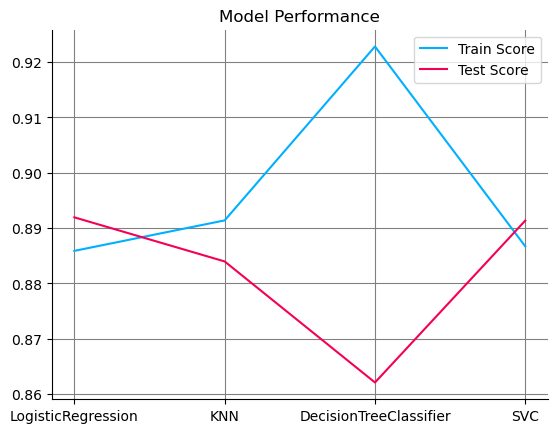

In [41]:
# plot for train and test scores
plt.title('Model Performance')
plt.plot(model_perf_df['model'],model_perf_df['train_score'],label='Train Score')
plt.plot(model_perf_df['model'],model_perf_df['test_score'],label='Test Score')
plt.legend()
plt.grid()
plt.show()


DecisionTreeClassifier has highest training score but lowest test score so its overfitting. The other 3 models Logistic Regression, KNN and SVC are performing about the same in terms of train and test scores.

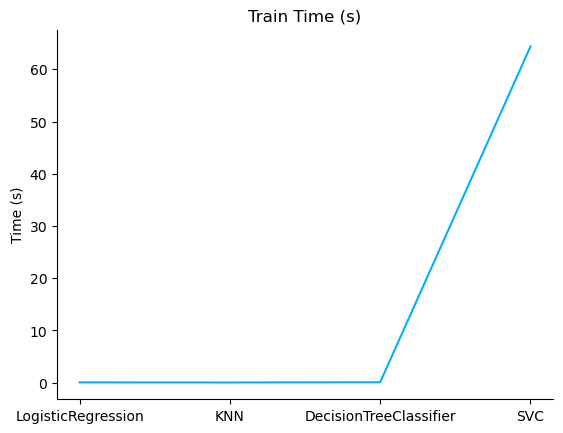

In [42]:
#plot for training time
plt.title('Train Time (s)')
plt.plot(model_perf_df['model'],model_perf_df['train_time'])
plt.ylabel('Time (s)')
plt.show()


SVC model is taking loger than other model in training time.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [43]:
# build a method to tune hyper parameters of various models using GridSearchCV
def tune_model(model,grid_params):
    gs = GridSearchCV(model,param_grid=grid_params, scoring="accuracy", cv=5).fit(X_train,y_train)
    gs_train_score = gs.score(X_train,y_train)
    gs_test_score = gs.score(X_test,y_test)
    return gs,gs_train_score,gs_test_score

# create a function for confusion matrix plot
def plot_confusion_matrix(gs): 
    cm = confusion_matrix(y_test,gs.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gs.classes_)
    disp.plot() 

#### Logistic Regression
Tune hyper paramters of Logistic Regression.

In [44]:
log_reg = LogisticRegression()
parameters = {
    "penalty":["l1", "l2", "elasticnet"],
    "C": [10,50,100],
    "max_iter": [10,50,100],
    "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
log_reg_gs,lg_reg_train_score,log_reg_test_score = tune_model(log_reg,parameters)
print(log_reg_gs.best_estimator_)

LogisticRegression(C=10, max_iter=10, penalty='l1', solver='liblinear')


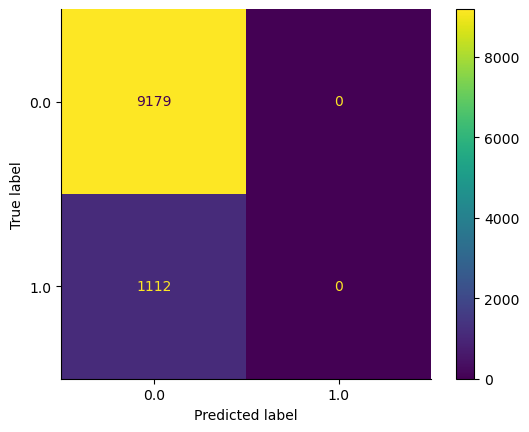

In [45]:
plot_confusion_matrix(log_reg_gs)

The model did 1112 wrong predictions out of 10291 which is almost 10% wrong, so the model perfomance is 90% which is above the basic Logistic Regression (89%). So hyper parater tuning improved the model performance.

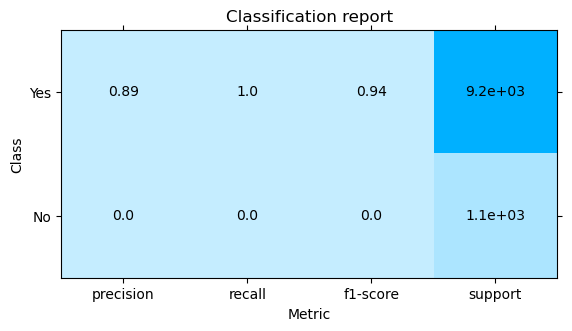

In [46]:
plot.ClassificationReport.from_raw_data(
    y_test,log_reg_gs.predict(X_test), target_names=["Yes","No"]
)

#### KNN
Lets build KNN model and tune hyper parameters.

In [47]:
knn_m = KNeighborsClassifier()
params = {
    "n_neighbors": np.array(range(1,8)) # picked the neighbours of the features counts
}
knn_gs,knn_gs_train_score,knn_gs_test_scaore = tune_model(knn_m,params)
print(knn_gs.best_estimator_)

KNeighborsClassifier(n_neighbors=6)


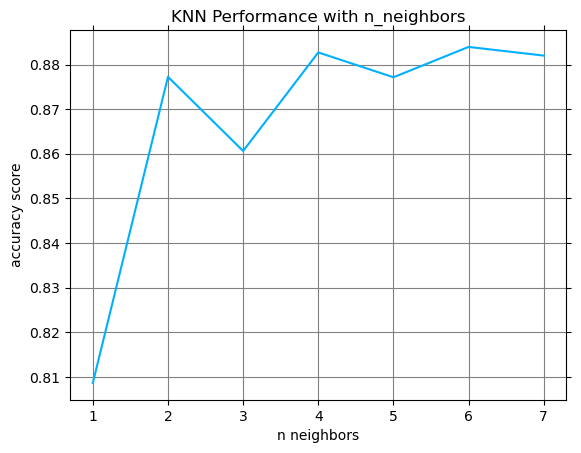

In [48]:
# create a dataframe of GridSearchCV results
gs_df = pd.DataFrame(knn_gs.cv_results_,columns=knn_gs.cv_results_.keys())

plt.title('KNN Performance with n_neighbors')
plt.plot(gs_df['param_n_neighbors'],gs_df['mean_test_score'])
plt.grid()
plt.xlabel("n neighbors")
plt.ylabel("accuracy score")
plt.show()

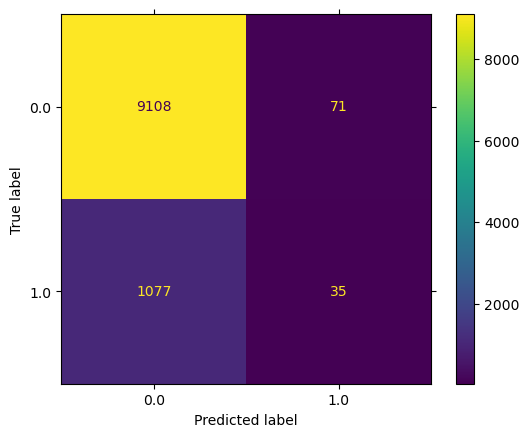

In [49]:
plot_confusion_matrix(knn_gs)

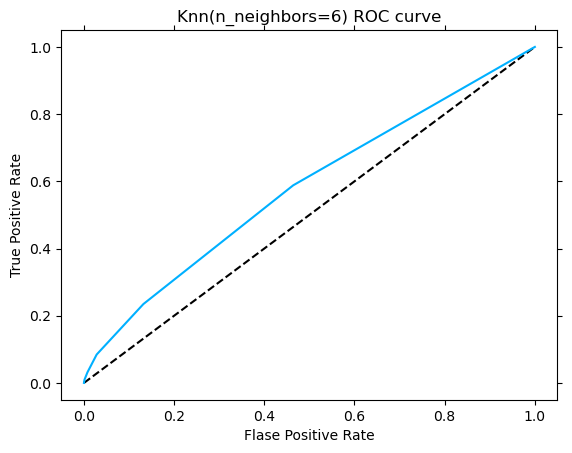

In [50]:
# Lets evaluate roc curve score
y_pred_proba = knn_gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Knn(n_neighbors=6) ROC curve')
plt.show()

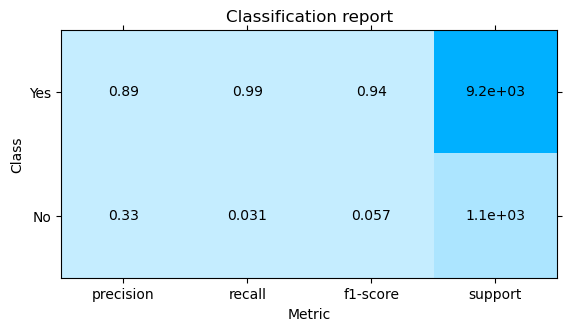

In [51]:
plot.ClassificationReport.from_raw_data(
    y_test, knn_gs.predict(X_test), target_names=["Yes","No"]
)

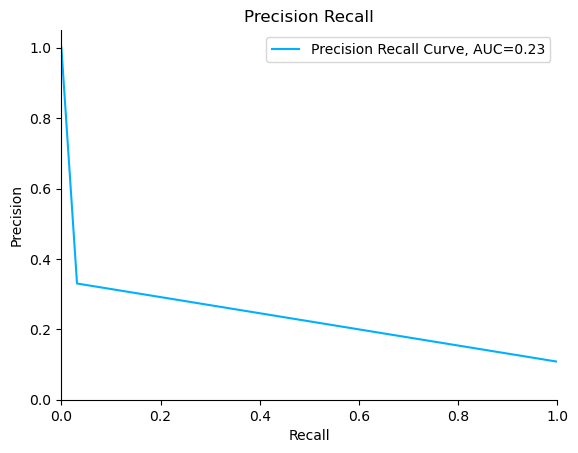

In [52]:
plot.PrecisionRecall.from_raw_data(y_test, knn_gs.predict(X_test))

#### Decision Tree Classifier

In [53]:
tree_m = DecisionTreeClassifier()
tree_parameter = {
"max_depth": np.array(range(1,50))
}
tree_gs,tree_gs_train_score,tree_gs_test_score = tune_model(tree_m,tree_parameter)
print(tree_gs.best_estimator_)

DecisionTreeClassifier(max_depth=4)


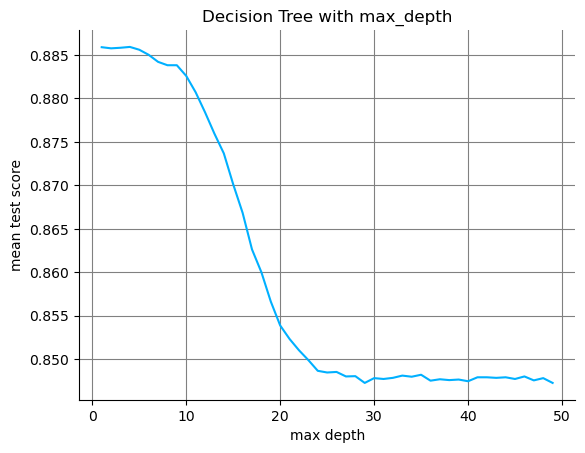

In [54]:
gs_df = pd.DataFrame(tree_gs.cv_results_,columns=tree_gs.cv_results_.keys())

plt.title('Decision Tree with max_depth')
plt.plot(gs_df['param_max_depth'],gs_df['mean_test_score'])
plt.grid()
plt.xlabel("max depth")
plt.ylabel("mean test score")
plt.show()

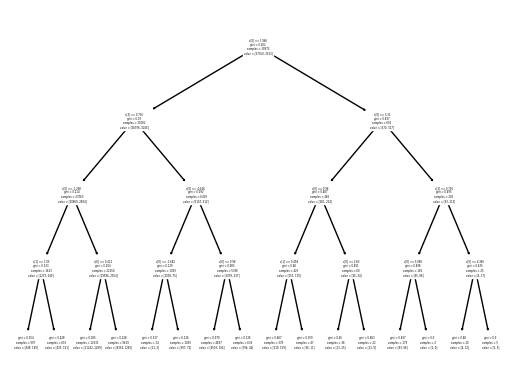

In [55]:
tree.plot_tree(tree_gs.best_estimator_)
plt.show()

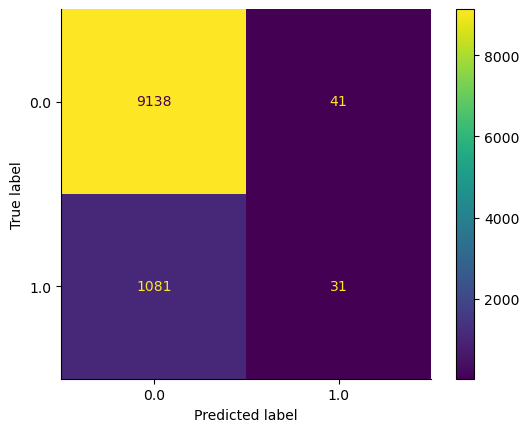

In [56]:
plot_confusion_matrix(tree_gs)

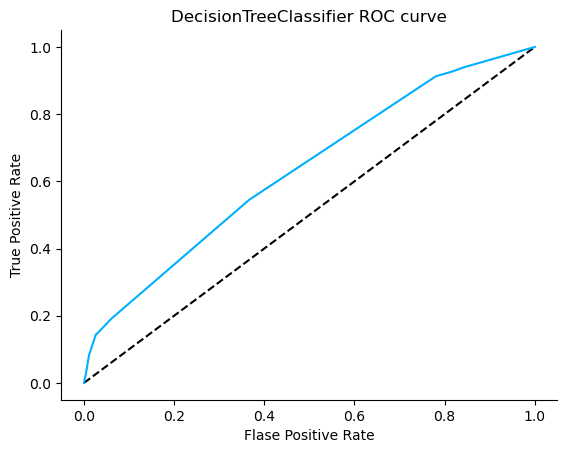

In [57]:
# Lets evaluate roc curve score
y_pred_proba = tree_gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DecisionTreeClassifier ROC curve')
plt.show()

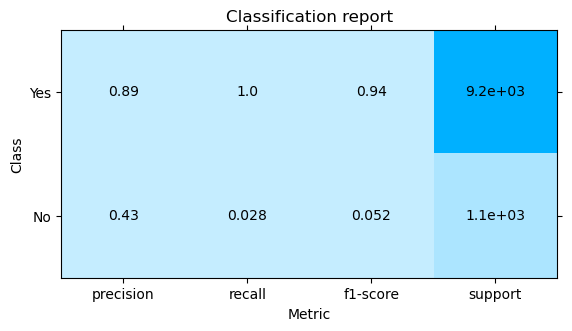

In [58]:
plot.ClassificationReport.from_raw_data(
    y_test, tree_gs.predict(X_test), target_names=["Yes","No"]
)

#### SVM

In [60]:
from sklearnex import patch_sklearn, config_context
patch_sklearn()
svc = SVC(random_state=42)
svc_parameters = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid']
}
svc_gs,svc_gs_train_score,svc_gs_test_score = tune_model(svc,svc_parameters)
print(svc_gs.best_estimator_)

ModuleNotFoundError: No module named 'sklearnex'

##### Questions